In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score  
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [12]:
df=pd.read_csv("salaries.csv")
pd.set_option('mode.chained_assignment', None)

In [13]:
df=df.drop(['salary' ], axis=1)

num_vars = df.select_dtypes(include=['float64', 'int64'])
cat_vars = df.select_dtypes(include=['object', 'category'])
target_variable='salary_in_usd'

for vars in cat_vars:
    if(np.max(df[vars].value_counts()/len(df))>0.99):
        print(df[vars].value_counts())
       # sns.barplot(y=target_variable, x=vars, data=df) # before dropping it i make a plot to understand if it has interestin information
        df=df.drop(vars, axis=1)
        cat_vars=cat_vars.drop(vars, axis=1)
        
cat_vars_1=[]
for vars in cat_vars:
    if(np.min(df[vars].value_counts()/len(df))<0.005):
        cat_vars_1.append(vars)
        
for var in cat_vars_1:
    label_counts = df[var].value_counts(normalize=True)
    labels_to_change = label_counts[label_counts < 0.01].index
    df[var]=df[var].apply(lambda x: 'other' if x in labels_to_change else x)
    
remote_dict = {0: 'No remote', 
               50: 'Partially remote', 
               100: 'Fully remote'}
df['remote_ratio'] = df['remote_ratio'].replace(remote_dict)
num_vars = df.select_dtypes(include=['float64', 'int64'])
cat_vars = df.select_dtypes(include=['object', 'category'])

discrete_vars=[] 
continue_vars=[]
for vars in num_vars:
    levels=df[vars].nunique()
    if levels<len(df)/100:   # i 
        discrete_vars.append(vars)
    else:
        continue_vars.append(vars)
    print(levels, 'levels:', vars)

employment_type
FT    7932
CT      18
PT      13
FL      11
Name: count, dtype: int64
4 levels: work_year
1616 levels: salary_in_usd


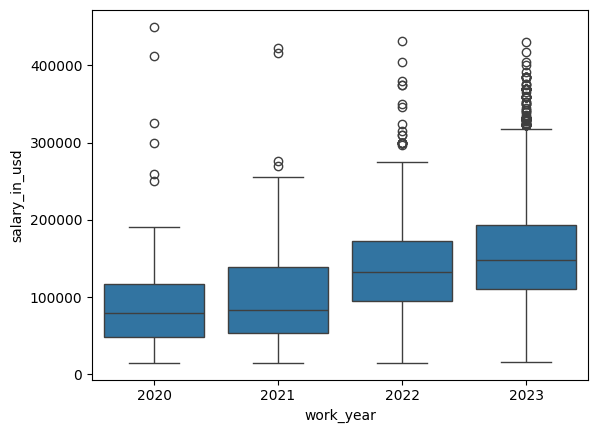

In [14]:
sns.boxplot(x='work_year', y='salary_in_usd', data=df)
plt.show()

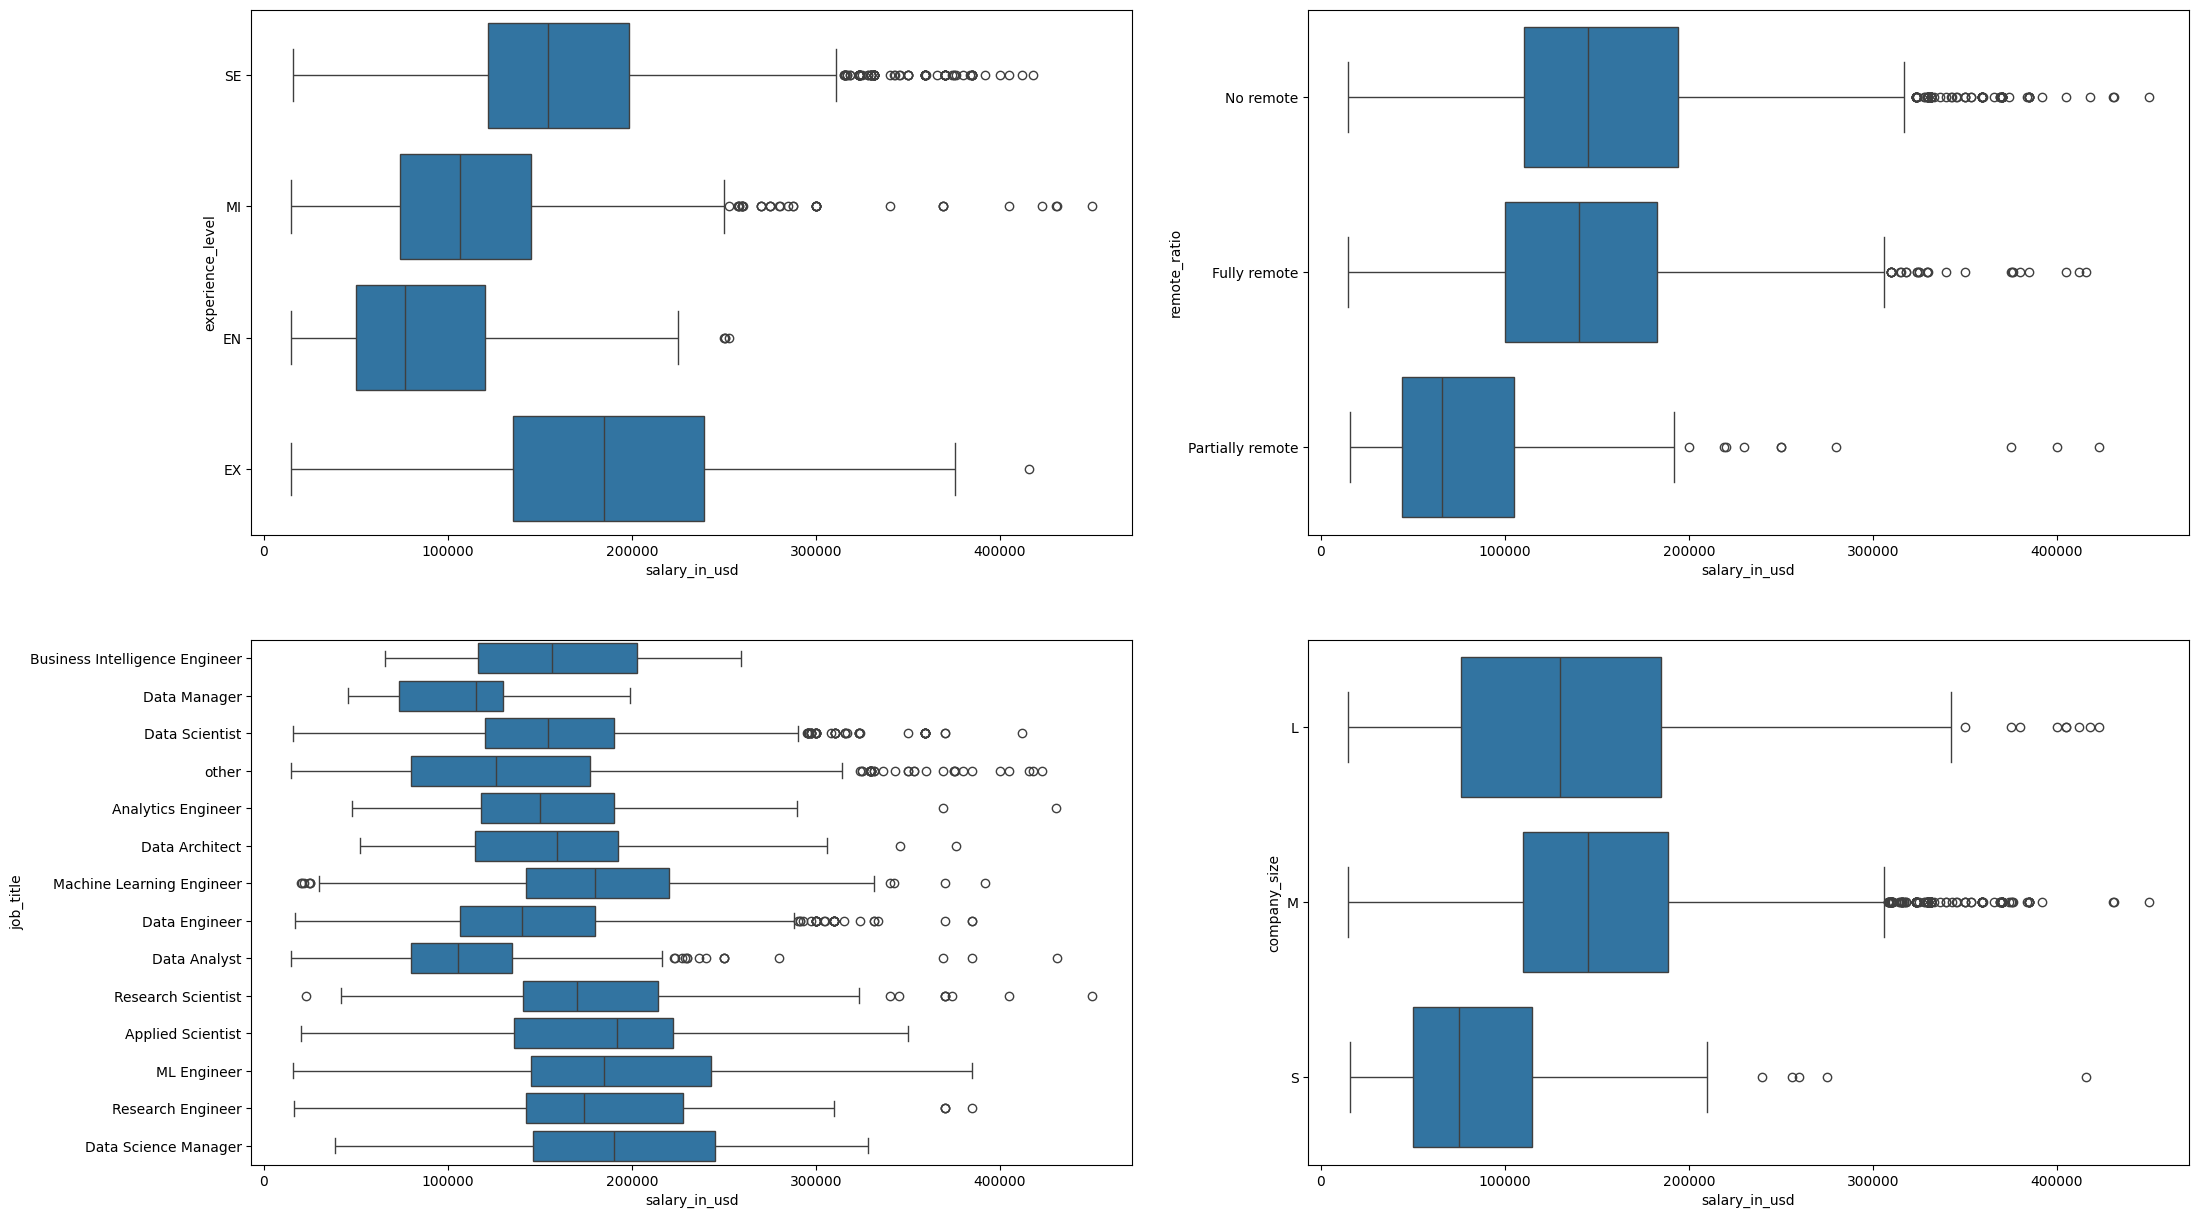

In [15]:
figure, axes = plt.subplots(2, 2, figsize=(25,15)) 
sns.boxplot(ax=axes[0,0],x='salary_in_usd', y='experience_level', data=df)
sns.boxplot(ax=axes[1,0],x='salary_in_usd', y='job_title', data=df)
sns.boxplot(ax=axes[0,1],x='salary_in_usd', y='remote_ratio', data=df)
sns.boxplot(ax=axes[1,1],x='salary_in_usd', y='company_size', data=df)
plt.show()

In [17]:
df = pd.get_dummies(df, columns=cat_vars.columns)
data_X=df.drop(target_variable, axis=1)
data_y=df[target_variable]
train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, random_state = 0)

In [18]:
param_grid_rf = {
    'n_estimators': [50,100,200],
    'max_depth': [10,15,20],
    'min_samples_split': [5,10]}

# Create the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Instantiate GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, 
                           cv=5, n_jobs=-1, verbose=0)

# Perform Grid Search to find the best parameters
grid_search_rf.fit(train_X, train_y)

# Best parameters and best estimator
best_params = grid_search_rf.best_params_
rf_model = grid_search_rf.best_estimator_
best_params

725.04s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
725.12s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
725.12s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
725.14s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
725.15s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
725.17s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
725.17s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
725.19s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
725.20s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 100}

In [19]:
rf_model.fit(train_X, train_y)
rf_pred=rf_model.predict(test_X)
rf_mape = mean_absolute_percentage_error(test_y, rf_pred)
rf_mape

0.31688369679842104

In [21]:
def plot_feature_importance(importance,names,model_type, n):

#Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

#Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df=fi_df.iloc[0:n,:]

#Define size of bar plot
    plt.figure(figsize=(10,8))
#Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(rf_model.feature_importances_,train_X.columns,'RANDOM FOREST',15)